# Mosaic from a single multitemporal dataset


The goal of this notebook is to provide an example of how to create a cloud-free mosaic from Sentinel-2 imagery over a specific area over a period of time. First, we use `satsearch` to search for Sentinel-2 data, then we combine the returned images using `stackstac`. Finally, a median operation is applied to merge the images into a single layer that can be saved as COGs in Azure blob storage for later use.


## 1. Sentinel-2 Dataset

Satellite images (also Earth observation imagery, spaceborne photography, or simply satellite photos) are images of Earth collected by imaging satellites typically operated by governments and businesses around the world (see https://en.wikipedia.org/wiki/Satellite_imagery). Major applications include Earth observation and land-cover monitoring. 


SENTINEL-2 (https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/overview) is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including monitoring of vegetation, soil and water cover and observation of inland waterways and coastal areas.

## 2. Environment setup

The libraries we'll need are listed below.

In [1]:
import numpy as np
import xarray as xr
import rioxarray
import datashader as ds
from datashader import Canvas

import stackstac
from satsearch import Search

import xrspatial.multispectral as ms

## 2.1. Dask local cluster

In [2]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)

## 3. Load Sentinel 2 data

In this example, we use image data from the `sentinel-s2-l2a-cogs` collection within a bounding box of `[-97.185642, 27.569157, -95.117574, 29.500710]`, and in the time range from `2019-07-01` to `2020-06-30`. And, we use only images with less than 25% cloud coverage.

In [3]:
items = Search(
    url='https://earth-search.aws.element84.com/v0',
    bbox=[-96.185642, 28.569157, -95.117574, 29.500710],
    collections=['sentinel-s2-l2a-cogs'],
    query={'eo:cloud_cover': {'lt': 25}},
    datetime='2019-07-01/2020-06-30'
).items()

len(items)

216

Let's combine all the above STAC items into a lazy xarray with following settings:
- projection: epsg=32613
- resolution: 100m
- bands: red (B04), green (B03), blue (B02)

In [4]:
stack_ds = stackstac.stack(
    items, epsg=32613, resolution=100, assets=['B04', 'B03', 'B02'], chunksize=4096
)

stack_ds

,Array,Chunk
Bytes,22.03 GiB,34.81 MiB
Shape,"(216, 3, 2148, 2124)","(1, 1, 2148, 2124)"
Count,1945 Tasks,648 Chunks
Type,float64,numpy.ndarray


This gives us all the image layers in one DataArray, but this is still quite a lot of images (216). We can simplify this a bit by resampling and combining the image layers for each month using a median calculation:

In [5]:
monthly = stack_ds.resample(time='MS').median('time', keep_attrs=True)
monthly.data = monthly.data.rechunk(1024, 1024)
monthly

<xarray.DataArray 'stackstac-65521696683a65d1cdf387e00f0ff832' (time: 12, band: 3, y: 2148, x: 2124)>
dask.array<rechunk-merge, shape=(12, 3, 2148, 2124), dtype=float64, chunksize=(12, 3, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * time                        (time) datetime64[ns] 2019-07-01 ... 2020-06-01
  * band                        (band) <U3 'B04' 'B03' 'B02'
  * x                           (x) float64 1.281e+06 1.281e+06 ... 1.493e+06
  * y                           (y) float64 3.329e+06 3.329e+06 ... 3.115e+06
    instruments                 <U3 'msi'
    constellation               <U10 'sentinel-2'
    ...                          ...
    title                       (band) <U14 'Band 4 (red)' ... 'Band 2 (blue)'
    proj:shape                  object {10980}
    common_name                 (band) <U5 'red' 'green' 'blue'
    center_wavelength           (band) float64 0.6645 0.56 0.4966
    full_width_half_max         (band) float64 0.038 0.045 0.098
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(1281000, 3114600, 1493400, 33...
    crs:         epsg:32613
    transform:   | 100.00, 0.00, 1281000.00|\n| 0.00,-100.00, 3329400.00|\n| ...
    resolution:  100

Now we have a much more manageable DataArray with 12 image layers (each with 3 bands) for 12 months.

## 4. Cloud-free scene using median operator

In this final stage, we use a median operation to merge all the monthly images into 1 single cloud-free layer. We use the assumption that, in a stack of images that are multitemporal, clouds wouldn't persist at the same geographical position from time to time. Hence, the more data we have, the better our chances of dropping the clouds.

First, we'll combine the data, still in the xarray lazy mode, using the median operation.

In [6]:
median_scene = monthly.median(dim=['time'])
median_scene.data = median_scene.data.rechunk(2048, 2048)
median_scene

<xarray.DataArray 'stackstac-65521696683a65d1cdf387e00f0ff832' (band: 3, y: 2148, x: 2124)>
dask.array<rechunk-merge, shape=(3, 2148, 2124), dtype=float64, chunksize=(3, 2048, 2048), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * band                        (band) <U3 'B04' 'B03' 'B02'
  * x                           (x) float64 1.281e+06 1.281e+06 ... 1.493e+06
  * y                           (y) float64 3.329e+06 3.329e+06 ... 3.115e+06
    instruments                 <U3 'msi'
    constellation               <U10 'sentinel-2'
    gsd                         int64 10
    ...                          ...
    title                       (band) <U14 'Band 4 (red)' ... 'Band 2 (blue)'
    proj:shape                  object {10980}
    common_name                 (band) <U5 'red' 'green' 'blue'
    center_wavelength           (band) float64 0.6645 0.56 0.4966
    full_width_half_max         (band) float64 0.038 0.045 0.098
    epsg                        int64 32613

## 5. Downsample for visualization

Finally, we'll generate an image of the cloud-free scene we just constructed using `xrspatial.multispectral`'s `true_color` function. 

We'll use the 3 bands we chose from the start - red, green, blue - and we'll first downsample and transform them into an image raster. Then, we'll apply true_color and get our image.

In [7]:
h, w = 600, 800
canvas = Canvas(plot_height=h, plot_width=w)
resampled_agg = canvas.raster(median_scene)
resampled_agg

<xarray.DataArray 'transpose-dfcebc0ab182f7846d17d45d8cb90bf5' (band: 3, y: 600, x: 800)>
dask.array<transpose, shape=(3, 600, 800), dtype=float64, chunksize=(1, 600, 800), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 1.281e+06 1.281e+06 1.282e+06 ... 1.493e+06 1.493e+06
  * y        (y) float64 3.329e+06 3.329e+06 3.329e+06 ... 3.115e+06 3.115e+06
  * band     (band) <U3 'B04' 'B03' 'B02'
Attributes:
    res:      100.0

`true_color` function takes 3 bands: red, green, blue as inputs and returns a PIL.Image object

In [8]:
image = ms.true_color(resampled_agg[2], resampled_agg[1], resampled_agg[0])
image

<xarray.DataArray 'stack-042f92d0e402063af79ee5cc7ddf9936' (y: 600, x: 800, band: 4)>
dask.array<stack, shape=(600, 800, 4), dtype=uint8, chunksize=(600, 800, 1), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 3.329e+06 3.329e+06 3.329e+06 ... 3.115e+06 3.115e+06
  * x        (x) float64 1.281e+06 1.281e+06 1.282e+06 ... 1.493e+06 1.493e+06
  * band     (band) int64 0 1 2 3

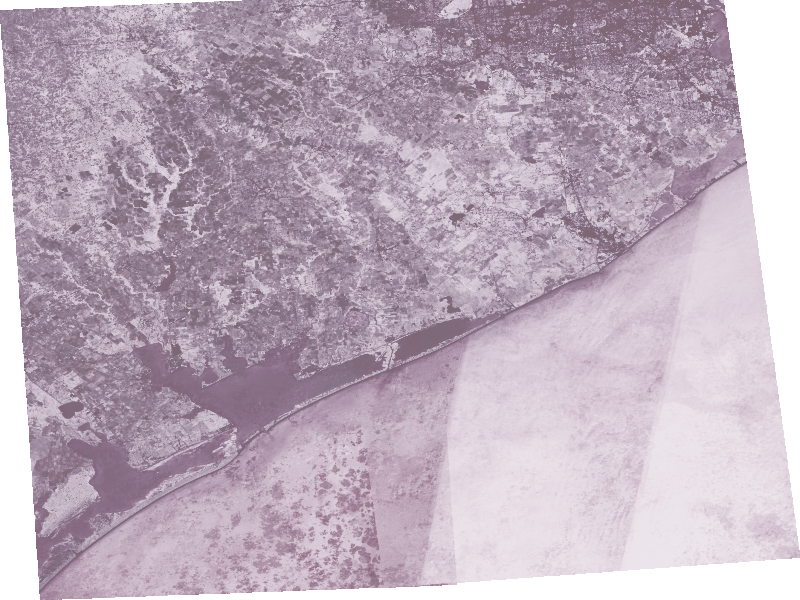

In [9]:
ds.tf.shade(image)